<a href="https://colab.research.google.com/github/Egoago/Onlab/blob/main/%C3%96nlab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D regression

In [10]:
#@title Imports
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors
from math import ceil
import tensorflow as tf
from tensorflow import norm
from tensorflow.math import reduce_mean, abs
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Dense, Input, Dropout, ReLU, Softmax, Concatenate, ELU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.initializers import RandomNormal, Zeros, Constant
from pylab import cm,imshow,contour,clabel,colorbar
import keras
from keras import backend as K
from keras.layers import Layer
import pandas as pd

##Preparing the data

###Control points

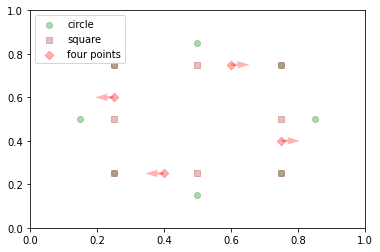

In [11]:
np.random.seed(1)
square = np.array([
                   [0.25,0.25],
                   [0.5,0.25],
                   [0.75,0.25],
                   [0.75,0.5],
                   [0.75,0.75],
                   [0.5,0.75],
                   [0.25,0.75],
                   [0.25,0.5]
                   ])
circle = np.array([
                   [0.25,0.25],
                   [0.5,0.15],
                   [0.75,0.25],
                   [0.85,0.5],
                   [0.75,0.75],
                   [0.5,0.85],
                   [0.25,0.75],
                   [0.15,0.5]
                   ])
fourPoints = np.array([
                   [0.4,0.25],
                   [0.75,0.4],
                   [0.6,0.75],
                   [0.25,0.6],
                   ])
normals = np.array([
                   [-1.0,0.0],
                   [1.0,0.0],
                   [1.0,0.0],
                   [-1.0,0.0],
                   ])
plt.scatter(circle[:,0], circle[:,1], c='green', marker='o', label='circle', alpha=0.3)
plt.scatter(square[:,0], square[:,1], c='brown', marker='s', label='square', alpha=0.3)
plt.scatter(fourPoints[:,0], fourPoints[:,1], c='red', marker='D', label='four points', alpha=0.3)
plt.quiver(fourPoints[:,0], fourPoints[:,1], normals[:,0], normals[:,1], color='red', alpha=0.3)
plt.legend(loc='upper left')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

###Data Scaler

[0.5 0.5]
0.25


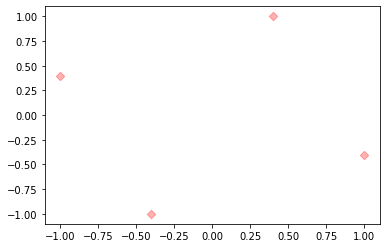

In [12]:
class Scaler():
  def __init__(self, data):
    self.data = data
    self.mean = np.mean(data, axis=0)
    self.scale = np.max(np.abs(data-self.mean))
    self.trainingData = self.transform(data)
  
  def getTrainingData(self):
    return self.trainingData

  def getMean(self):
    return self.mean

  def getScale(self):
    return self.scale

  def transform(self, x):
    return (x-self.mean)/self.scale

scaler = Scaler(fourPoints)
print(scaler.getMean())
print(scaler.getScale())
scaled = scaler.getTrainingData()
plt.scatter(scaled[:,0], scaled[:,1], c='red', marker='D', label='scaled four points', alpha=0.3)
plt.show()

###Data generator

In [13]:
class DataGenerator(Sequence):
  seed = 0
  def __init__(self, batchCount, batchSize, controlPoints, controlNormals=None):
    self.controlPoints = controlPoints
    self.controlNormals = controlNormals
    self.batchCount = batchCount
    self.batchSize = batchSize
    self.seed = DataGenerator.seed
    DataGenerator.seed += 1
    self.randGen = np.random.default_rng(seed=self.seed)

  def __len__(self):
    return self.batchCount

  def __getitem__(self, idx):
    P = []
    for i in range(self.batchSize):
      p = self.randGen.random(2)
      P.append(p)
    return np.array(P), self.controlPoints, controlNormals

  #def on_epoch_end(self):
    #self.randGen = np.random.default_rng(seed=self.seed)

##Creating model

In [14]:
class CustomModel(Model):
  def __init__(self, eikonalLambda = 0.1, normalLambda = 1,*args, **kwargs):
    super(CustomModel, self).__init__(*args, **kwargs)
    self.eikonalLambda = eikonalLambda
    self.normalLambda = normalLambda
    self.initialWeights = self.get_weights()

  def train_step(self, data):
    volumePoints, surfacePoints, surfaceNormals = data
    trainableVariables = self.trainable_variables

    with tf.GradientTape() as backpropTape:
      backpropTape.watch(trainableVariables)

      #Volume-eikonal
      with tf.GradientTape() as eikonalTape:
        eikonalTape.watch(volumePoints)
        volumePred = self(volumePoints, training=True)
      volumeGrad = eikonalTape.gradient(volumePred, volumePoints)
      eikonalLoss = tf.cast(reduce_mean((norm(volumeGrad, 2, -1) - 1) ** 2), dtype='float32')

      #Surface
      with tf.GradientTape() as surfaceTape:
        surfaceTape.watch(surfacePoints)
        surfacePred = self(surfacePoints, training=True)
      surfaceAbs = abs(surfacePred)
      if surfaceNormals is not None:
        surfaceGrad = surfaceTape.gradient(surfacePred, surfacePoints)
        surfaceAbs += self.normalLambda*norm(surfaceGrad-surfaceNormals, 2, -1)
      surfaceLoss = reduce_mean(surfaceAbs)

      loss = surfaceLoss + self.eikonalLambda * eikonalLoss

    self.optimizer.minimize(loss, trainableVariables, tape=backpropTape)
    return {"loss": loss}
  
  def test_step(self, data):
    volumePoints, surfacePoints, surfaceNormals = data

    #Volume-eikonal
    with tf.GradientTape() as eikonalTape:
      eikonalTape.watch(volumePoints)
      volumePred = self(volumePoints, training=True)
    volumeGrad = eikonalTape.gradient(volumePred, volumePoints)
    eikonalLoss = tf.cast(reduce_mean((norm(volumeGrad, 2, -1) - 1) ** 2), dtype='float32')

    #Surface
    with tf.GradientTape() as surfaceTape:
      surfaceTape.watch(surfacePoints)
      surfacePred = self(surfacePoints, training=True)
    surfaceAbs = abs(surfacePred)
    if surfaceNormals is not None:
      surfaceGrad = surfaceTape.gradient(surfacePred, surfacePoints)
      surfaceAbs += self.normalLambda*norm(surfaceGrad-surfaceNormals, 2, -1)
    surfaceLoss = reduce_mean(surfaceAbs)

    loss = surfaceLoss + self.eikonalLambda * eikonalLoss
    return {"loss": loss}
  
  def reset(self):
    self.set_weights(self.initialWeights)

In [15]:
#@title Softer Relu activation { display-mode: "form" }
class SofterRelu(Layer):
  def sRelu(x, beta=100):
    return K.log(K.exp(x*beta) + 1)/beta

  def __init__(self, beta=100, trainable=False, **kwargs):
      super(SofterRelu, self).__init__(**kwargs)
      self.supports_masking = True
      self.beta = beta
      self.trainable = trainable

  def build(self, input_shape):
      self.beta_factor = K.variable(self.beta,
                                    dtype=K.floatx(),
                                    name='beta_factor')
      if self.trainable:
          self._trainable_weights.append(self.beta_factor)

      super(SofterRelu, self).build(input_shape)

  def call(self, inputs, mask=None):
      return SofterRelu.sRelu(inputs, self.beta_factor)

  def get_config(self):
      config = {'beta': self.get_weights()[0] if self.trainable else self.beta,
                'trainable': self.trainable}
      base_config = super(SofterRelu, self).get_config()
      return dict(list(base_config.items()) + list(config.items()))

  def compute_output_shape(self, input_shape):
      return input_shape



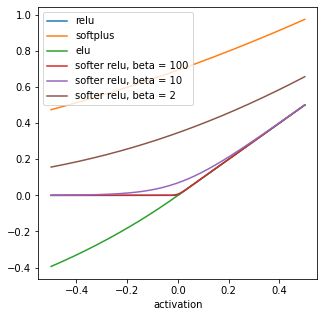

In [16]:
#@title Plotting functions { display-mode: "form" }
def plotActivations():
  df = pd.DataFrame({"activation": np.linspace(-0.5,0.5,200)})
  df["relu"] = K.eval(keras.activations.relu(df["activation"]))
  df["softplus"] = K.eval(keras.activations.softplus(df["activation"]))
  df["elu"] = K.eval(keras.activations.elu(df["activation"]))
  df["softer relu, beta = 100"] = K.eval(SofterRelu()(df["activation"]))
  df["softer relu, beta = 10"] = K.eval(SofterRelu(10)(df["activation"]))
  df["softer relu, beta = 2"] = K.eval(SofterRelu(2)(df["activation"]))
  df.plot(x="activation", figsize=(5,5))

def plot(model, controlPoints=None, controlNormals=None, plotSize='big'):
    sizeDict = {
        'big': ((13,10), 200, 0.05),
        'medium': ((8,5), 100, 0.1),
        'small': ((4,3), 40, 0.2),
    }
    figSize, resolution, lineDensity = sizeDict[plotSize]
    plt.figure(figsize=figSize)
    grid = np.empty((resolution*resolution,2))
    for y in range(resolution):
      for x in range(resolution):
        grid[y*resolution+x] = [x/resolution, y/resolution]
    prediction = np.array(model.predict(grid).reshape((resolution,resolution)))
    grid = []

    max = np.max(prediction)
    min = np.min(prediction)
    if (abs(min) > max):
      max = abs(min)
    im = imshow(prediction,
                cmap = sns.diverging_palette(220, 20, as_cmap=True),
                origin='lower',
                norm = colors.Normalize(vmin=-max, vmax=max))
    plt.axis('off')
    colorbar(im)
    cset = contour(prediction,np.arange(-0.6,0.6,lineDensity),linewidths=2,cmap='gray_r')
    clabel(cset,inline=True,fmt='%1.2f',fontsize=10)
    if controlPoints is not None:
      plot = sns.scatterplot(x=controlPoints[:,0]*resolution,
                      y=controlPoints[:,1]*resolution,
                      color = 'grey',
                      s = 80,
                      linewidth = 0)
      if controlNormals is not None:
        plt.quiver(controlPoints[:,0]*resolution,
                  controlPoints[:,1]*resolution,
                  controlNormals[:,0],
                  controlNormals[:,1],
                  color='grey',
                  headlength = 3,
                  scale = 15,
                  headaxislength=3)
    prediction = []
    plt.show()

class PlotCallback(Callback):
  def __init__(self, model, controlPoints=None, controlNormals=None, step=2):
    self.model = model
    self.controlPoints = controlPoints
    self.controlNormals = controlNormals
    self.step = step
    self.plots = []

  def on_train_begin(self, logs=None):
    print('Initial weights')
    plot(self.model, controlPoints, controlNormals, plotSize='medium')

  def on_epoch_end(self, epoch, logs=None):
    if (epoch%self.step == 0):
      plot(self.model, controlPoints, controlNormals, plotSize='small')
plotActivations()

Trainable variables: 575


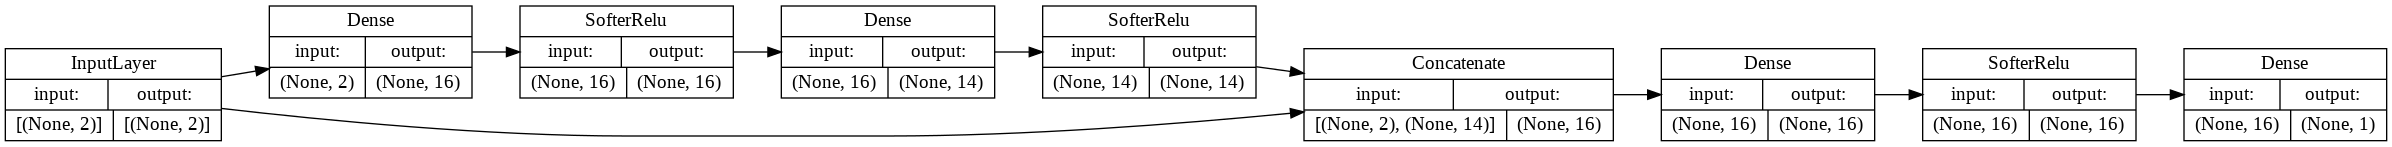

In [17]:
#@title Structure { run: "auto", form-width: "50%", display-mode: "form" }
layerCount = 3 #@param {type:"slider", min:1, max:8, step:1}
skipLayer = 2 #@param {type:"slider", min:0, max:8, step:1}
layerNeurons = 16 #@param {type:"slider", min:8, max:64, step:8}
activation = "softerRelu" #@param ["relu", "softmax", "softerRelu", "elu"]
activationParam = 10 #@param {type:"number"}
learningRate = 0.0015 #@param {type:"slider", min:0.0005, max:0.002, step:0.0001}

def getActivation():
  if activation == "softerRelu":
    return SofterRelu(activationParam)
  elif activation == "elu":
    return ELU(activationParam)
  elif activation == "relu":
    return ReLU()
  elif activation == "softmax":
    return Softmax()

inputLayer = Input(shape=(2,))
prevLayer = inputLayer
for i in range(1,layerCount+1):
  neurons = layerNeurons-2 if i == skipLayer else layerNeurons
  hiddenLayer = Dense(neurons,
                     kernel_initializer=RandomNormal(stddev=np.sqrt(2)/np.sqrt(neurons)),
                     bias_initializer=Zeros())(prevLayer)
  prevLayer = getActivation()(hiddenLayer)
  if i == skipLayer:
    prevLayer = Concatenate()([inputLayer,prevLayer])
outputLayer = Dense(1,
                    activation='linear',
                    kernel_initializer= RandomNormal(mean=np.pi/np.sqrt(neurons), stddev=0.00001),
                    bias_initializer=Constant(-0.5)
                    )(prevLayer)

model = CustomModel(inputs = inputLayer, outputs = outputLayer)
model.compile(optimizer = Adam(lr = 0.0015))
#model.summary()
print(f'Trainable variables: {np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])}')
keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, rankdir='LR')


Initial weights


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: No contour levels were found within the data range.


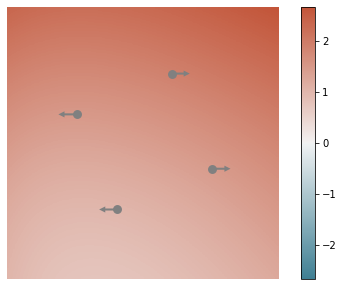

Epoch 1/10
10000/10000 [==============================] - 20s 2ms/step - loss: 0.0389


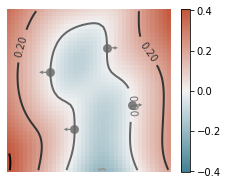

Epoch 2/10
10000/10000 [==============================] - 18s 2ms/step - loss: 0.0094


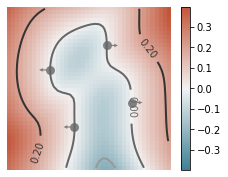

Epoch 3/10
10000/10000 [==============================] - 18s 2ms/step - loss: 0.0082


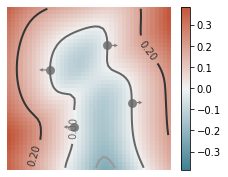

Epoch 4/10
10000/10000 [==============================] - 18s 2ms/step - loss: 0.0073


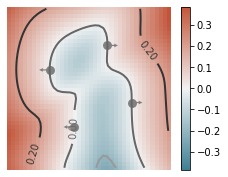

Epoch 5/10
10000/10000 [==============================] - 18s 2ms/step - loss: 0.0068


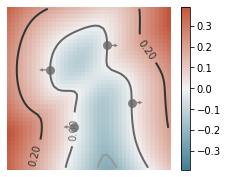

Epoch 6/10
10000/10000 [==============================] - 18s 2ms/step - loss: 0.0063


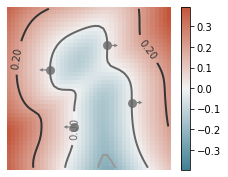

Epoch 7/10
10000/10000 [==============================] - 18s 2ms/step - loss: 0.0060


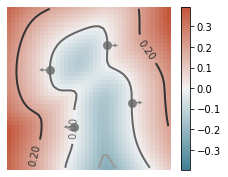

Epoch 8/10
10000/10000 [==============================] - 19s 2ms/step - loss: 0.0058


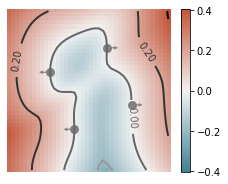

Epoch 9/10
10000/10000 [==============================] - 19s 2ms/step - loss: 0.0055


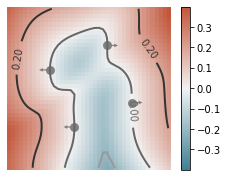

Epoch 10/10
10000/10000 [==============================] - 19s 2ms/step - loss: 0.0052


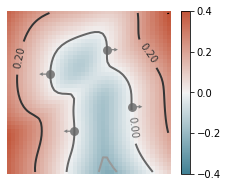

In [18]:
#@title Train
batchCount = 10000 #@param {type:"integer"}
batchSize = 4 #@param {type:"integer"}
epochs = 10 #@param {type:"integer"}
useNormals = True #@param {type:"boolean"}
reset = False #@param {type:"boolean"}
save = 'weights1' #@param {type:"string"}

controlPoints = fourPoints
controlNormals = normals if useNormals else None
if reset:
  model.reset()
history = model.fit(DataGenerator(batchCount = batchCount,
                                  batchSize = batchSize,
                                  controlPoints = controlPoints,
                                  controlNormals = controlNormals),
                    verbose = 1,
                    callbacks = [PlotCallback(model, controlPoints, controlNormals, 1)],
                    epochs = epochs)
if len(save)>0:
  model.save_weights('./saves/' + save)

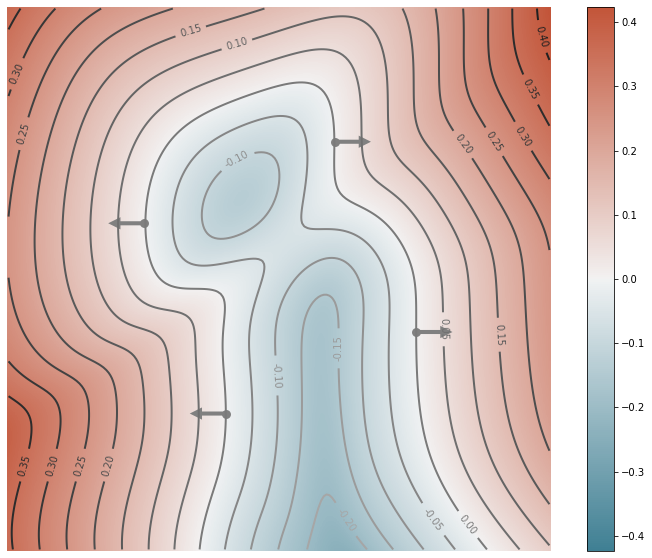

In [19]:
plot(model, controlPoints, controlNormals)